In [1]:
from components.dataset_jo import Dataset_subjectDependent as MyDataset
from components.preprocessing import preprocess_interface, standardize, DE, ASYM, PCC

dataset = MyDataset(dataset_path='data', lazyload=True)
lenght = 12
dataset.set_segment(7680//(128*60))
data, labels, groups = dataset.get_data('all', stimuli=1, return_type='numpy')
# X = DE(data, variant='asd')
# X = standardize(X)

Found: 32 files


In [34]:
from sklearn.model_selection import StratifiedGroupKFold,GridSearchCV,StratifiedKFold
n_split_outter = 10
cv_outter = StratifiedGroupKFold(n_splits=n_split_outter, shuffle=False)
train_1 = list(cv_outter.split(X, labels, groups))

cv_outter_2 = StratifiedGroupKFold(n_splits=n_split_outter, shuffle=False)
train_2 = list(cv_outter_2.split(X, labels, groups))

In [43]:
for a,b in zip(train_1, train_2):
    train = (a[0] == b[0]).all()
    test = (a[1] == b[1]).all()
    print(train == test)

True
True
True
True
True
True
True
True
True
True


In [55]:
import numpy as np
def _calculate_fft(signal, sfreq):
    """ signal: can be 1D array of (n_sample,) or 2D array of (n_signal, n_sample)  """
    # the result will be a complex number. We can obtain the magnitude using `absolute`
    magnitude = np.abs(np.fft.fft(signal, sfreq))
    # scale the result
    magnitude = magnitude / (sfreq/2)
    # Selecting the range
    magnitude = magnitude.T[:sfreq//2].T
    freq_range= np.fft.fftfreq(128, d=1/128)[:128//2]
    return magnitude



In [36]:
from components.preprocessing import convert_to_mne
import mne
epochs = convert_to_mne(data)
epochs = mne.preprocessing.compute_current_source_density(epochs)
data_time = epochs.get_data()  

Fitted sphere radius:         95.3 mm
Origin head coordinates:      -0.8 15.1 45.3 mm
Origin device coordinates:    -0.8 15.1 45.3 mm


(640,)
(1, 1, 64) (64,)
[[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.]]]


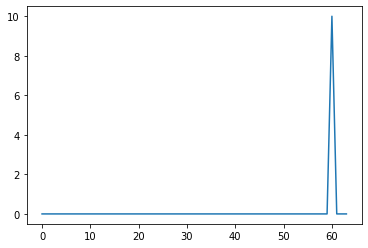

In [56]:
import matplotlib.pyplot as plt
t = np.arange(0,5,1/128)
print(t.shape)
f = 60
data_time = np.sin(t * 2 * np.pi * f).reshape(1,1,-1) * 10

data_freq = _calculate_fft(data_time, 128)

freq_range= np.fft.fftfreq(128, d=1/128)[:128//2]
print(data_freq.shape, freq_range.shape)
plt.plot(freq_range, data_freq[0,0])
data_freq[data_freq < 0.001] = 0
print(data_freq)


In [30]:
np.fft.fftfreq(128, d=1/128)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63., -64., -63.,
       -62., -61., -60., -59., -58., -57., -56., -55., -54., -53., -52.,
       -51., -50., -49., -48., -47., -46., -45., -44., -43., -42., -41.,
       -40., -39., -38., -37., -36., -35., -34., -33., -32., -31., -30.,
       -29., -28., -27., -26., -25., -24., -23., -22., -21., -20., -19.,
       -18., -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,
        -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.])

In [34]:
data.shape, data_time.shape, data_freq.shape

((1280, 32, 7680), (1280, 32, 7680), (1280, 32, 128))

In [11]:
indices = np.array_split(np.arange(data.shape[0]), 1)

In [12]:
indices

[array([    0,     1,     2, ..., 76797, 76798, 76799])]

In [111]:
import glob
import os
import pandas as pd
import re
import numpy as np

In [117]:
def get_10_cv(file_path):
    pattern = "10-CV"
    lines = []
    with open(file_path, 'r') as f:
        # last_line = f.readlines()[-1]
        for line in f:
            if(re.search(pattern,line)):
                if(re.search("final",line)):
                    continue
                else:
                    lines.append(line)
    return lines

def get_result(file_path):
    lines = get_10_cv(file_path)
    # print(log)
    try:
        assert len(lines) == 32 or len(lines) == 1, len(lines)
    except:
        print(file_path, "not done")
    if(file_path == ""):
        print(lines)
    cvs, stds = [], []
    for line in lines:
        try:
            time,log_type,msg,cv_txt,std_txt,elapse = line.split('|')
            assert log_type == 'INFO', f"{line}"
            cv = float(cv_txt.split('=')[1])
            std = float(std_txt.split('=')[1])
            cvs.append(cv)
            stds.append(std)
        except Exception as e:
            print(file_path, line, e)
            raise e
    return round(np.array(cvs).mean(),5), round(np.array(stds).mean(),5)

In [118]:
path_files = glob.glob("output/*/*dependent*.log")
df = pd.DataFrame(columns=["subject_setup", "experimental_setup", "preprocess", "segment_lenght", "stimuli", "cv", "std"])
for path_file in path_files:
    # print(f)
    path, filename = os.path.split(path_file)
    # print(path, filename)
    filename, ext = os.path.splitext(filename)
    subject_setup, experimental_setup, stimuli,  preprocess, segment_lenght = filename.split('-')
    # print(subject_setup, experimental_setup, stimuli, preprocess, segment_lenght)
    try:
        cv, std = get_result(path_file)
        row = {
            "subject_setup": subject_setup,
            "experimental_setup": experimental_setup,
            "segment_lenght": segment_lenght,
            "stimuli": stimuli,
            "preprocess": preprocess,
            "cv": cv,
            "std": std
        }
        a = pd.DataFrame.from_records([row])
        df= pd.concat([df, a], axis=0)
    except Exception as e:
            # print(file_path, line, e)
            raise e
    # break
df.to_csv("output/ml.csv")

output/PCC_TIME/dependent-trial-valence-PCC_TIME-1.log not done


In [121]:
df = pd.read_csv("output/ml.csv")
# for preprocess in ["DE","DASM","RASM","DCAU","PCC_TIME","PCC_FREQ","PLV","PLI"]:
for subject_setup in ["dependent","independent"]:
    for experimental_setup in ["segment", 'trial']:
        for segment_lenght in [1,12,20,60]:
            for preprocess in ["DASM","RASM","DCAU"]:
                rows = df.loc[
                    (df["subject_setup"] == subject_setup) &
                    (df["experimental_setup"] ==  experimental_setup) &
                    (df["segment_lenght"] ==  segment_lenght) &
                    (df["preprocess"] ==  preprocess)
                ]
                if(len(rows) == 0): 
                    print(f"{subject_setup}-{experimental_setup}-sti-{preprocess}-{segment_lenght} has not run")
                elif(len(rows) == 1):
                    print(rows)
                    raise ValueError
                else:
                    print(f"{subject_setup}-{experimental_setup}-sti-{preprocess}-{segment_lenght}", round(rows['cv'].mean(),3), round(rows['std'].mean(),3), sep="\t")
                # pass
            # for sti in ["arousal","valence"]:


dependent-segment-sti-DASM-1	0.642	0.022
dependent-segment-sti-RASM-1	0.634	0.018
dependent-segment-sti-DCAU-1	0.643	0.019
dependent-segment-sti-DASM-12	0.664	0.076
dependent-segment-sti-RASM-12	0.661	0.077
dependent-segment-sti-DCAU-12	0.662	0.077
dependent-segment-sti-DASM-20	0.658	0.101
dependent-segment-sti-RASM-20	0.665	0.107
dependent-segment-sti-DCAU-20	0.66	0.104
dependent-segment-sti-DASM-60	0.626	0.191
dependent-segment-sti-RASM-60	0.613	0.178
dependent-segment-sti-DCAU-60	0.621	0.182
dependent-trial-sti-DASM-1	0.619	0.09
dependent-trial-sti-RASM-1	0.606	0.092
dependent-trial-sti-DCAU-1	0.622	0.093
dependent-trial-sti-DASM-12	0.626	0.117
dependent-trial-sti-RASM-12	0.626	0.117
dependent-trial-sti-DCAU-12	0.628	0.114
dependent-trial-sti-DASM-20	0.629	0.125
dependent-trial-sti-RASM-20	0.633	0.128
dependent-trial-sti-DCAU-20	0.634	0.13
dependent-trial-sti-DASM-60	0.63	0.181
dependent-trial-sti-RASM-60	0.62	0.18
dependent-trial-sti-DCAU-60	0.625	0.173
independent-segment-sti-DASM

In [ ]:
dependent-segment-sti-DASM-1	0.642	0.022
dependent-segment-sti-RASM-1	0.634	0.018
dependent-segment-sti-DCAU-1	0.643	0.019
dependent-segment-sti-DASM-12	0.664	0.076
dependent-segment-sti-RASM-12	0.661	0.077
dependent-segment-sti-DCAU-12	0.662	0.077
dependent-segment-sti-DASM-20	0.658	0.101
dependent-segment-sti-RASM-20	0.665	0.107
dependent-segment-sti-DCAU-20	0.66	0.104
dependent-segment-sti-DASM-60	0.626	0.191
dependent-segment-sti-RASM-60	0.613	0.178
dependent-segment-sti-DCAU-60	0.621	0.182
dependent-trial-sti-DASM-1	0.619	0.09
dependent-trial-sti-RASM-1	0.606	0.092
dependent-trial-sti-DCAU-1	0.622	0.093
dependent-trial-sti-DASM-12	0.626	0.117
dependent-trial-sti-RASM-12	0.626	0.117
dependent-trial-sti-DCAU-12	0.628	0.114
dependent-trial-sti-DASM-20	0.629	0.125
dependent-trial-sti-RASM-20	0.633	0.128
dependent-trial-sti-DCAU-20	0.634	0.13
dependent-trial-sti-DASM-60	0.63	0.181
dependent-trial-sti-RASM-60	0.62	0.18
dependent-trial-sti-DCAU-60	0.625	0.173
independent-segment-sti-DASM-1	0.562	0.012
independent-segment-sti-RASM-1	0.564	0.0
independent-segment-sti-DCAU-1	0.553	0.022
independent-segment-sti-DASM-12	0.517	0.062
independent-segment-sti-RASM-12	0.506	0.08
independent-segment-sti-DCAU-12	0.538	0.044
independent-segment-sti-DASM-20	0.434	0.124
independent-segment-sti-RASM-20	0.459	0.079
independent-segment-sti-DCAU-20	0.466	0.099
independent-segment-sti-DASM-60	0.409	0.116
independent-segment-sti-RASM-60	0.461	0.109
independent-segment-sti-DCAU-60	0.434	0.127
independent-trial-sti-DASM-1	0.562	0.006
independent-trial-sti-RASM-1	0.564	0.003
independent-trial-sti-DCAU-1	0.562	0.005
independent-trial-sti-DASM-12	0.558	0.026
independent-trial-sti-RASM-12	0.564	0.006
independent-trial-sti-DCAU-12	0.56	0.016
independent-trial-sti-DASM-20	0.585	0.023
independent-trial-sti-RASM-20	0.571	0.017
independent-trial-sti-DCAU-20	0.578	0.033
independent-trial-sti-DASM-60	0.615	0.022
independent-trial-sti-RASM-60	0.59	0.032
independent-trial-sti-DCAU-60	0.619	0.04